<a href="https://colab.research.google.com/github/Lianyihwei/RobbiLian/blob/master/FinanceWithPython_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 介紹Python有關股市的幾個api來搜集、整理股票料，並介紹常技術分析語法及回測方法
#### python有不少可以搜集股票資訊的api，除非要練習爬蟲，建議使用這些api，一來下載資料速度較快，二來可以避免大量爬網站造成伺服器負擔
#### 這次我們主要使用yahoo finance api來下載資料，另外有pandas-**datareader與ffn可使用
#### 使用googlecolab或jupyternotebook需先安裝相關套件

## 先安裝所有要用到的套件
## 如果是在本地端電腦安裝，直接輸入pip install <套件名稱>  前面不用+!

In [ ]:
!pip install yfinance
!pip install yfinance --upgrade --no-cache-dir
!pip install --upgrade ffn
!pip install --upgrade pandas
!pip install --upgrade backtrader
!pip install plotly==5.3.1
# plotly==5.3.1 work kaleido well
!pip install -U kaleido
!pip install talib-binary

## yfinance下載股票資料與基本操作

In [5]:
import yfinance as yf
import pandas_datareader as web
import pandas as pd
import numpy as np
import datetime

# yfinance 美股直接用代號如aapl、tsla。台股是代號加上.tw
# 下載的區間可以用 start=開始日期，end=結束日期，或是下面的範例用periods從今天開始往前算的區間加上間隔
# 區間 periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# 間隔 intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
ticker_symbol = "2330.tw"
tsmc = yf.download(tickers=ticker_symbol, period="3y", interval="1d")
print(tsmc.tail())
print(type(tsmc))

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close    Volume
Date                                                       
2022-06-24  489.5  492.5  485.5  486.5      486.5  27911980
2022-06-27  496.0  506.0  495.5  498.5      498.5  37909718
2022-06-28  496.0  500.0  496.0  497.5      497.5  15274062
2022-06-29  496.0  498.5  491.0  491.0      491.0  30533789
2022-06-30  484.5  486.5  476.0  476.0      476.0  49001392
<class 'pandas.core.frame.DataFrame'>


## Moving Average 代表過去一段時間裡的平均成交價格，主要目的是用來判斷趨勢及市場現在跟未來可能走勢，公式：
MA = (A1 + A2 + ……….An) / n

In [6]:
# 計算MA120, MA20, MA60
# 使用pandas函式rolling(n).mean()就可以計算出n天內的平均指，也可用max(),min(),std()計簡n天內的最大，小，標準差
tsmc["MA5"] = tsmc.Close.rolling(5).mean()
tsmc["MA20"] = tsmc.Close.rolling(20).mean()
tsmc["MA60"] = tsmc.Close.rolling(60).mean()
tsmc["MA240"] =tsmc.Close.rolling(240).mean()
tsmc.tail()

,Open,High,Low,Close,Adj Close,Volume,MA5,MA20,MA60,MA240
Date,,,,,,,,,,
2022-06-24,489.5,492.5,485.5,486.5,486.5,27911980,493.9,521.625,538.075000,586.877083
2022-06-27,496.0,506.0,495.5,498.5,498.5,37909718,494.0,520.050,536.566667,586.504167
2022-06-28,496.0,500.0,496.0,497.5,497.5,15274062,492.5,517.575,534.858333,586.114583
2022-06-29,496.0,498.5,491.0,491.0,491.0,30533789,491.8,514.125,533.091667,585.693750
2022-06-30,484.5,486.5,476.0,476.0,476.0,49001392,489.9,510.475,531.208333,585.202083


## 產生圖表，使用plotly可簡單產出互動式圖表

均線的黃金與死亡交叉  
短期、中期、長期的移動平均線常互相纏繞或交錯，它們交錯的地方，就稱作「黃金交叉」或「死亡交叉」

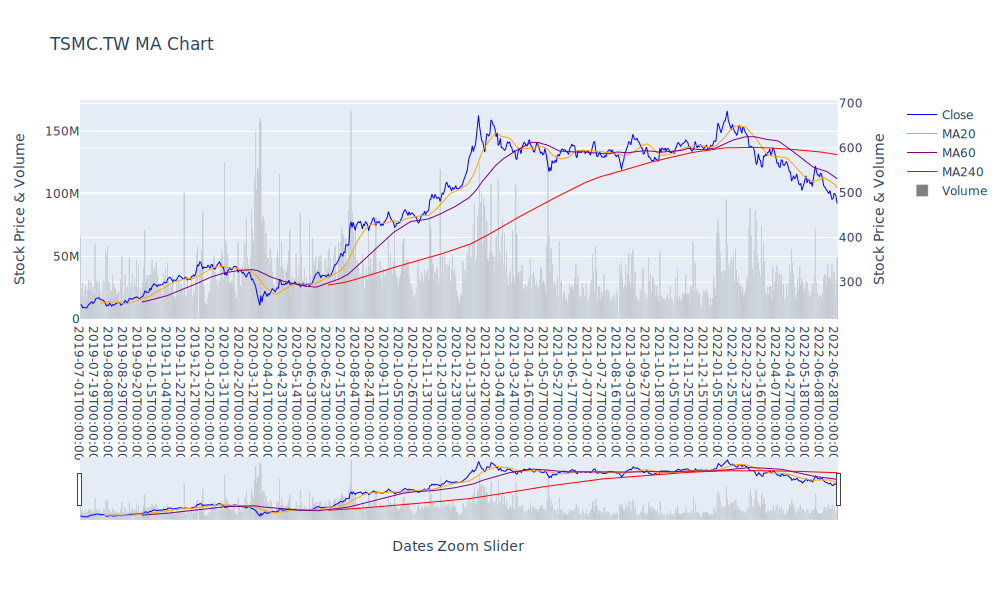

In [15]:
# import plot與相關套件
import plotly
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

# 產生plotly內要繪製的圖形內容 tsmc.Close = tsme["Close"]
close = go.Scatter(x = tsmc.index, y = tsmc.Close, line = dict(color = "blue", width = 1), name = "Close")
# ma5 = go.Scatter(x = tsmc.index, y = tsmc.MA5, line = dict(color = "yellow", width = 1), name = "MA5")
ma20 = go.Scatter(x = tsmc.index, y = tsmc.MA20, line = dict(color = "orange", width = 1), name = "MA20")
ma60 = go.Scatter(x = tsmc.index, y = tsmc.MA60, line = dict(color = "purple", width = 1), name = "MA60")
ma240 = go.Scatter(x = tsmc.index, y = tsmc.MA240, line = dict(color = "red", width = 1), name = "MA240")

# 產生vloume(成交量)的長條圖
vol = go.Bar(x=tsmc.index, y=tsmc.Volume, name="Volume", marker_color = "gray")

# 設定畫布有第二個Y軸指標
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(trace=close, secondary_y=True)
# fig.add_trace(trace=ma5, secondary_y=True)
fig.add_trace(trace=ma20, secondary_y=True)
fig.add_trace(trace=ma60, secondary_y=True)
fig.add_trace(trace=ma240, secondary_y=True)
fig.add_trace(trace=vol, secondary_y=False)

# 設定畫布layout
fig.update_layout(title="TSMC.TW MA Chart", width=1000, height=600)

# plotly 有一個小缺點是沒有資料的日期會留空白，資料量多不明顯，但如果期間短看起來就會有斷層
# 有2個語法可以把不要的日期從plot中移除，bounds是
fig.update_xaxes(rangeslider_visible=True, title = "Dates Zoom Slider")
# 方法一，設定xaxis.type = "category"
fig.layout.xaxis.type = "category"
# 方法二，用xaxis_rangebreaks把bang掉指定區間(bounds)或日期(value)(如資料單位為min，可用dict(bounds=[13.5, 9], pattern="hour")把收盤時間ban掉 )
# fig.update_layout(wrangeslider_visible=True, title = "Dates Zoom Slider",
#                                 xaxis_rangebreaks = [dict(bounds = ["sat", "mon"])])
fig.update_yaxes(title="Stock Price & Volume")
# plotly產生互動式圖檔為.html，因github不支援所以這邊使用show("svg")
# 本地端可用fig.show()
fig.show("svg")

## 使用OHLC製作常用的candles圖

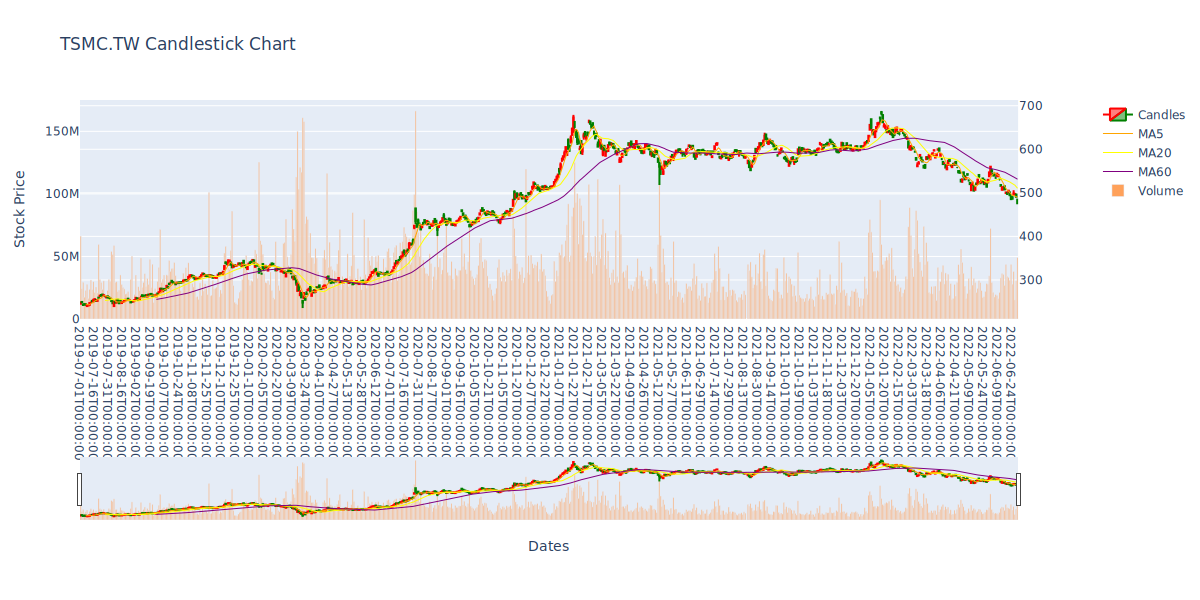

In [16]:
# 產生plotly內要繪製的圖形內容 tsmc.Open = tsme["Open"]
# 產生candles(台股漲紅跌綠，另外設定increasing_line_color= 'red', decreasing_line_color= 'green')
candles = go.Candlestick(x = tsmc.index, open = tsmc.Open, high = tsmc.High,
                                            low = tsmc.Low, close = tsmc.Close, name = "Candles",
                                            increasing_line_color= 'red', decreasing_line_color= 'green',)

# 產生ma5, ma20, ma60
ma5 = go.Scatter(x = tsmc.index, y = tsmc.MA5, line = dict(color = "orange", width = 1), name = "MA5")
ma20 = go.Scatter(x = tsmc.index, y = tsmc.MA20, line = dict(color = "yellow", width = 1), name = "MA20")
ma60 = go.Scatter(x = tsmc.index, y = tsmc.MA60, line = dict(color = "purple", width = 1), name = "MA60")

# 產生vloume(成交量)的長條圖
vol = go.Bar(x=tsmc.index, y=tsmc.Volume, name="Volume")

# 設定畫布有第二個Y軸指標
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 將產生的plots加入畫布,secondary_y=True 設定plot的y軸顯示在右邊的y軸，False是顯示在左邊
fig.add_trace(trace=candles, secondary_y=True)
fig.add_trace(trace=ma5, secondary_y=True)
fig.add_trace(trace=ma20, secondary_y=True)
fig.add_trace(trace=ma60, secondary_y=True)
fig.add_trace(trace=vol, secondary_y=False)

# 設定畫布layout-1增加區間選項按鈕 '5d', '15d, '1m', '3m', '6m', '1y', 'all'
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=5,
                     label="5D",
                     step="day",
                     stepmode="todate"),
                dict(count=15,
                     label="15D",
                     step="day",
                     stepmode="todate"),
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="todate"),
                dict(count=3,
                     label="3m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="3M",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(label="All", step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

# 設定畫布layout-2(可以加在上段後面) 為避免混亂習慣分開寫，設定x,y軸title，主title跟大小
fig.update_layout(xaxis_title="Dates", yaxis_title="Stock Price", 
                  title="TSMC.TW Candlestick Chart", 
                  width=1200, height=600)

# plotly 有一個小缺點是沒有資料的日期會留空白，資料量多不明顯，但如果期間短看起來就會有斷層
# 以下面的語法可以把不要的日期從plot中移除，bounds是ban掉指定區間(如資料內容包含到min，可用dict(bounds=[9, 13.5], pattern="hour")把收盤時間ban掉 )
# values是ban掉指定日期
fig.update_xaxes(rangeslider_visible=True)
# 如果設定xaxis.type = "category"，就會把無資料的日期從圖中ban掉，但會默認shared_xaxes為False
fig.layout.xaxis.type = "category"
# fig.show()
fig.write_html("2330TW.html", auto_open = True)
fig.show("svg")

## MACD (Moving Average Convergence / Divergence) 指數平滑異同移動平均線，長期與短期移動平均線收斂或發散的徵兆，加以雙重平滑處理，用來判斷買賣股票的時機與訊號。
###### MACD 指標組成有EMA(指數平滑移動平均線)，DIF(離差值)
###### 計算公式為 DIF(快線) = EMA12 - EMA26 ，DEM(慢線) = EMA(DIF，9)，OSC = DIF - DEM

[*********************100%***********************]  1 of 1 completed


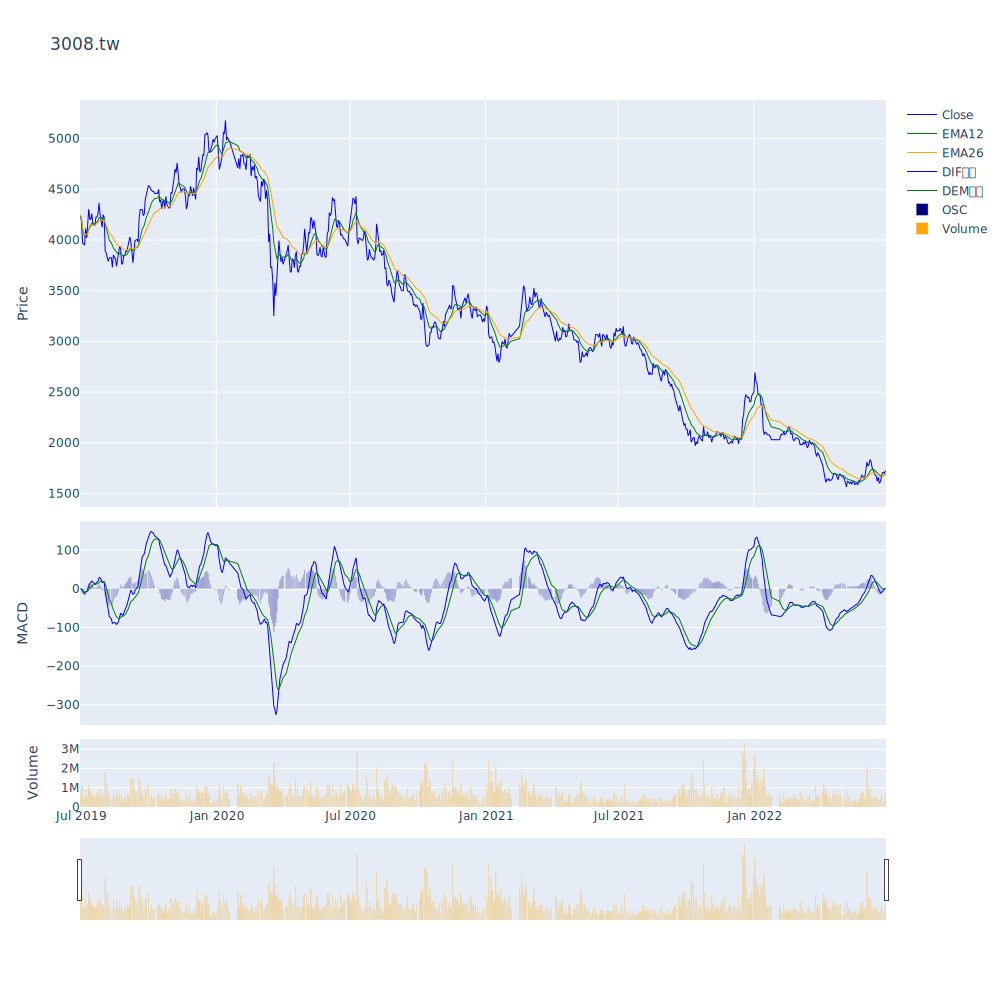

In [17]:
# 這裡將程式包成一個function()，方便之後檢視不同的股票各式指標與圖形
def ticker_macd(ticker, period_time, intervals_time):
    ticker_df = yf.download(tickers=ticker, period=period_time, interval=intervals_time)
    ticker_df["EMA12"] = ticker_df["Close"].ewm(span = 12).mean()
    ticker_df["EMA26"] = ticker_df["Close"].ewm(span = 26).mean()
    ticker_df["DIF"] = ticker_df["EMA12"] - ticker_df["EMA26"]
    ticker_df["DEM"] = ticker_df["DIF"].ewm(span = 9).mean()
    ticker_df["OSC"] = ticker_df["DIF"] - ticker_df["DEM"]

    fig = make_subplots(rows = 3, cols = 1, shared_xaxes = True, vertical_spacing = 0.02, row_heights=[0.6, 0.3, 0.1])
    fig.add_trace(go.Scatter(x = ticker_df.index, y=ticker_df["Close"], name = "Close",
                                                line = dict(color = "blue", width = 1)), 
                                            row = 1, col = 1)
    fig.add_trace(go.Scatter(x = ticker_df.index, y=ticker_df["EMA12"], name = "EMA12",
                                                line = dict(color = "green", width = 1)), 
                                            row = 1, col = 1)
    fig.add_trace(go.Scatter(x = ticker_df.index, y=ticker_df["EMA26"], name = "EMA26",
                                                line = dict(color = "orange", width = 1)), 
                                            row = 1, col = 1)
    fig.add_trace(go.Scatter(x = ticker_df.index, y=ticker_df["DIF"], name = "DIF快線",
                                                line = dict(color = "blue", width = 1)), 
                                            row = 2, col = 1)
    fig.add_trace(go.Scatter(x = ticker_df.index, y=ticker_df["DEM"], name = "DEM慢線",
                                                line = dict(color = "green", width = 1)), 
                                            row = 2, col = 1)
    fig.add_trace(go.Bar(x = ticker_df.index, y=ticker_df["OSC"],marker_color = "navy", name = "OSC"), 
                                            row = 2, col = 1)
    fig.add_trace(go.Bar(x = ticker_df.index, y=ticker_df["Volume"],marker_color = "orange", name = "Volume"), 
                                            row = 3, col = 1)
    fig.update_layout(title=ticker)
    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="MACD", row=2, col=1)
    fig.update_yaxes(title_text="Volume", row=3, col=1)
    fig.update_layout(width = 1000, height = 1000, xaxis_rangebreaks = [dict(bounds = ["sat", "mon"])],
                                xaxis3_rangeslider_visible = True, xaxis3_rangeslider_thickness=0.1)
    fig.show("svg")

ticker_macd("3008.tw", "3y", "1d")

## RSI(Relative Strength Index) 相對強弱指數
比較價格升降運動，以表達價格強度的技術分析工具，公式：  
RSI = EMA(U,n) / (EMA(U,n) + EMA(D,n)) * 100%
上漲時 U = 當日收盤價 - 前日收盤價，D = 0
下跌時 U = 0，D = 前日收盤價 - 當日收盤價  

根據威爾德（英語：J. Welles Wilder）的測量結果，當n=14時，指數最具代表性。他指出當某證券的RSI升至70時，代表該證券已被超買（Overbought），投資者應考慮出售該證券。相反，當證券RSI跌至30時，代表證券被超賣（Oversold），投資者應購入該證券。

[*********************100%***********************]  1 of 1 completed


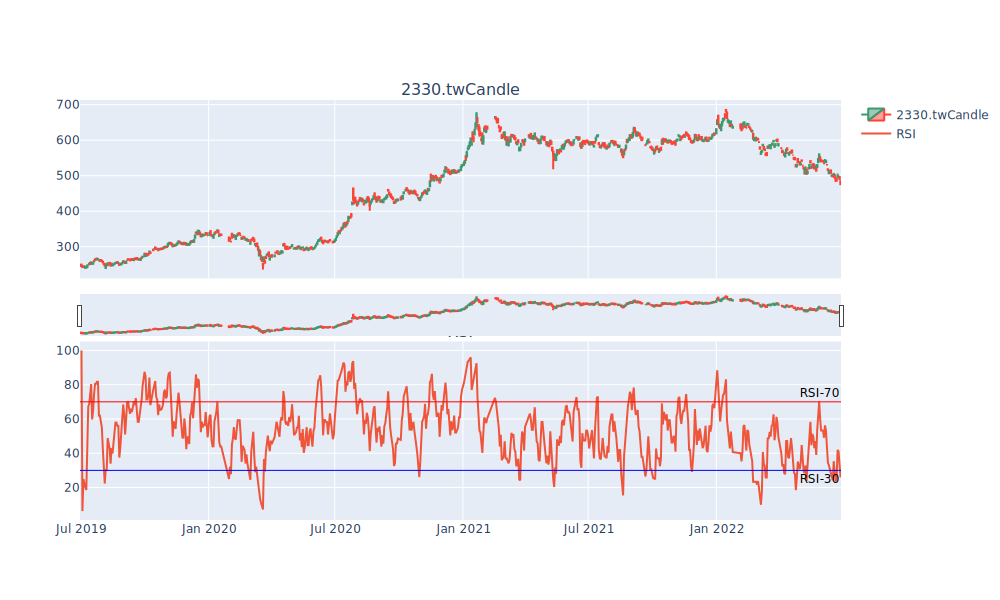

In [18]:
# ['DIF'] 每列之間 ['Close'] 的差值
# ['U'] 計算RSI內的U 利用['DIF']計算上漲時 U = 當日收盤價 - 前日收盤價，D = 0
# ['D'] 計算RSI內的D 利用['DIF']計算下跌時 U = 0，D = 前日收盤價 - 當日收盤價
# ['EMA14'] 計算 ['Close'] 14天指數移動平均
def ticker_rsi(ticker, period_time, intervals_time):
    ticker_df = yf.download(tickers=ticker, period=period_time, interval=intervals_time)
    ticker_df["DIF"] = ticker_df["Close"].diff()
    def cal_U(num):
        if num > 0:
            return num
        else:
            return 0
    def cal_D(num):
        num = -num
        return cal_U(num)
    ticker_df["U"] = ticker_df["DIF"].apply(cal_U)
    ticker_df["D"] = ticker_df["DIF"].apply(cal_D)
    ticker_df["EMAU"] = ticker_df["U"].ewm(span = 14).mean()
    ticker_df["EMAD"] = ticker_df["D"].ewm(span = 14).mean()
    ticker_df["RSI"] = ticker_df["EMAU"] / ( ticker_df["EMAU"] + ticker_df["EMAD"]) * 100
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.15, subplot_titles=(ticker+"Candle", "RSI"))
    candle = go.Candlestick(x=ticker_df.index, open=ticker_df["Open"], high=ticker_df["High"],
                                                low=ticker_df["Low"], close=ticker_df["Close"], name=ticker+"Candles")
    rsi = go.Scatter(x=ticker_df.index, y=ticker_df["RSI"], name="RSI")
    fig.add_trace(candle, row=1, col=1)
    fig.add_trace(rsi, row=2, col=1)
    fig.add_hline(y=70, line_width=1, line_color="red", annotation_text="RSI-70", row=2, col=1,
                            annotation_position="top right", annotation_font_color="black")
    fig.add_hline(y=30, line_width=1, line_color="blue", annotation_text="RSI-30", row=2, col=1,
                        annotation_position="bottom right", annotation_font_color="black")
    fig.update_xaxes(rangeslider_visible=True, rangeslider_thickness=0.1)
    fig.update_layout(height=600, width=1000, xaxis_rangebreaks = [dict(bounds = ["sat", "mon"])])
    fig.update_xaxes(rangeslider= {'visible':False}, row=2, col=1)
    fig.show("svg")

ticker_rsi("2330.tw", "3y", "1d")